In [24]:
from langgraph.graph import StateGraph, START, END
import os 
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm = ChatGroq(model="openai/gpt-oss-20b")

In [25]:
def add(a: int, b: int) -> int:
    """ Add a and b 
    Args:
        a (int): first int 
        b (int): second int 
    Returns:
        int
    """
    return a + b

In [26]:
# Binding tool with LLM 

llm_with_tools = llm.bind_tools([add])
llm_with_tools.invoke([HumanMessage(content="What is 5+2?", name="UserA")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks "What is 5+2?" We should use the add function.', 'tool_calls': [{'id': 'fc_8496a4b0-24bd-42e9-8d73-a7fe72ec7226', 'function': {'arguments': '{"a":5,"b":2}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 154, 'total_tokens': 199, 'completion_time': 0.047889923, 'prompt_time': 0.029566967, 'queue_time': 0.747089491, 'total_time': 0.07745689}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e99e93f2ac', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d806235a-e200-4a49-a02a-0a57a3a78477-0', tool_calls=[{'name': 'add', 'args': {'a': 5, 'b': 2}, 'id': 'fc_8496a4b0-24bd-42e9-8d73-a7fe72ec7226', 'type': 'tool_call'}], usage_metadata={'input_tokens': 154, 'output_tokens': 45, 'total_tokens': 199})

In [27]:
# Using messages as State

from langgraph.graph.message import add_messages
from typing import Annotated 
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    name: str


In [28]:
# Chatbot with functionality 
def llm_tool(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


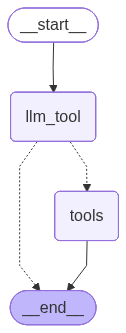

In [35]:
from IPython.display import Image, display 
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(State)

builder.add_node("llm_tool", llm_tool)
builder.add_node("tools", ToolNode([add]))

builder.add_edge(START, "llm_tool")
# If the latest message from assistant is a tool call, tools_condition routes to tools
# Otherwise tools_condition routes to END
builder.add_conditional_edges("llm_tool", tools_condition)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:


messages = graph.invoke({"messages": "What is 88 * 321?"})

print(messages)

{'messages': [HumanMessage(content='What is 88 + 321?', additional_kwargs={}, response_metadata={}, id='5c8f0ff0-d65d-49c0-8930-15caaa2f999b'), AIMessage(content='', additional_kwargs={'reasoning_content': 'User asks: "What is 88 + 321?" They want the sum. We should compute 88+321 = 409. We could also use the add function. Let\'s use the function.', 'tool_calls': [{'id': 'fc_2bacc872-edb6-49c5-8a74-f5e44be2ff3c', 'function': {'arguments': '{"a":88,"b":321}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 155, 'total_tokens': 223, 'completion_time': 0.067253994, 'prompt_time': 0.007469083, 'queue_time': 0.050906197, 'total_time': 0.074723077}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_80501ff3a1', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d4bd93bb-daef-4f36-a066-1afa8512583d-0', tool_calls=[{'name': 'add', 'args': {'a': 88, 'b': 321}, 'id': 'fc_2bacc872-